### Load packages
The cell below imports the `datacube` package, which already includes Dask functionality.
The `sys` package provides access to helpful support functions in the `dea_tools.dask` module, specifically the `create_local_dask_cluster` function.
The `dea_tools.plotting` module contains the function `rgb` which will allow us to plot the data we load using Dask.

In [1]:
import datacube

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import rgb

### Connect to the datacube
The next step is to connect to the datacube database.
The resulting `dc` datacube object can then be used to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [2]:
dc = datacube.Datacube(app="07_Parallel_processing_with_Dask")

## Enabling Dask

One of the major features of Dask is that it can take advantage of multiple CPU cores to speed up computations, which is known as distributed computing.
This is good for situations where you need to do a lot of calculations on large datasets.

To set up distributed computing with Dask, you need to first set up a Dask client using the function below:

In [3]:
client = create_local_dask_cluster(return_client=True)

2023-05-12 05:46:11,209 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-c8laaooo', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/saintly28@hotmail.com/proxy/8787/status,
Dashboard: /user/saintly28@hotmail.com/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38601,Workers: 1
Dashboard: /user/saintly28@hotmail.com/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:38679,Total threads: 2
Dashboard: /user/saintly28@hotmail.com/proxy/43791/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:43493,


A print out should appear, displaying information about the `Client` and the `Cluster`.
For now, we're most interested in the hyperlink after the **Dashboard:** heading, which should look something like [/user/\<username\>/proxy/8787/status](), where [\<username\>]() is your username.

This link provides a way for you to view how any computations you run are progressing. There are two ways to view the dashboard:
1. Click the link, which will open a new tab in your browser
2. Set up the dashboard inside the JupyterLab environment.

We'll now cover how to do the second option.

## Lazy load

When using Dask, the `dc.load()` function will switch from immediately loading the data to "lazy-loading" the data. 
This means the data is only loaded when it is going to be used for a calculation, potentially saving time and memory.

Lazy-loading changes the data structure returned from the `dc.load()` command: the returned `xarray.Dataset` will be comprised of `dask.array` objects.

To request lazy-loaded data, add a `dask_chunks` parameter to your `dc.load()` call:

In [4]:
lazy_ds = dc.load(product=["ga_ls5t_ard_3", "ga_ls7e_ard_3", "ga_ls8c_ard_3",
                  "ga_ls9c_ard_3"],
                  measurements=["nbart_green", "nbart_red", "nbart_blue", "nbart_nir", "nbart_swir_2", "oa_fmask"],
                  x=(150.00, 149.50),
                  y=(-37.25, -36.75),
                  time=('2020-01-14', '2020-04-14'),
                  dask_chunks={"time": 1, "x": 2048, "y": 2048})
resampling={
                   "fmask": "nearest",
                   "*": "bilinear"
               },



lazy_ds

<xarray.Dataset>
Dimensions:       (time: 39, y: 2033, x: 1730)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-16T23:50:51.864078 ... 2020-0...
  * y             (y) float64 -4.123e+06 -4.124e+06 ... -4.184e+06 -4.184e+06
  * x             (x) float64 1.554e+06 1.554e+06 ... 1.606e+06 1.606e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) int16 dask.array<chunksize=(1, 2033, 1730), meta=np.ndarray>
    nbart_red     (time, y, x) int16 dask.array<chunksize=(1, 2033, 1730), meta=np.ndarray>
    nbart_blue    (time, y, x) int16 dask.array<chunksize=(1, 2033, 1730), meta=np.ndarray>
    nbart_nir     (time, y, x) int16 dask.array<chunksize=(1, 2033, 1730), meta=np.ndarray>
    nbart_swir_2  (time, y, x) int16 dask.array<chunksize=(1, 2033, 1730), meta=np.ndarray>
    oa_fmask      (time, y, x) uint8 dask.array<chunksize=(1, 2033, 1730), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
# add a script to check variable names

The function should return much faster, as it is not reading any data from disk.

### Dask chunks

After adding the `dask_chunks` parameter to `dc.load()`, the lazy-loaded data contains `dask.array` objects with the `chunksize` listed.
The `chunksize` should match the `dask_chunks` parameter originally passed to `dc.load()`. 

Dask works by breaking up large datasets into chunks, which can be read individually. You may specify the number of pixels in each chunk for each dataset dimension.

For example, we passed the following chunk definition to `dc.load()`:
```
dask_chunks = {"time": 1, "x": 2048, "y": 2048}
```

This definition tells Dask to cut the data into chunks containing 2048 pixels in the `x` and `y` dimensions and one measurement in the `time` dimension. 
For DEA data, we always set `"time": 1` in the `dask_chunk` definition, since the data files only span a single time.

If a chunk size is not provided for a given dimension, or if it set to `-1`, then the chunk will be set to the size of the array in that dimension.
This means all the data in that dimension will be loaded at once, rather than being broken into smaller chunks.

### Viewing Dask chunks

To get a visual intuition for how the data has been broken into chunks, we can use the `.data` attribute provided by `xarray`. 
This attribute can be used on individual measurements from the lazy-loaded data.
When used in a Jupyter Notebook, it provides a table summarising the size of individual chunks and the number of chunks needed.

An example is shown below, using the `red` measurement from the lazy-loaded data:

In [5]:
lazy_ds.nbart_red.data

dask.array<dc_load_nbart_red, shape=(39, 2033, 1730), dtype=int16, chunksize=(1, 2033, 1730), chunktype=numpy.ndarray>

In [6]:
#MASK DATA FOR CLOUD

import scipy.ndimage
import xarray
import numpy
import datacube
from datacube.utils.masking import make_mask
from datacube.utils.masking import mask_invalid_data
from odc.algo import mask_cleanup

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import rgb

In [7]:
dc = datacube.Datacube(app="Masking_data")

In [8]:
lazy_ds.oa_fmask.attrs["flags_definition"]

{'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata',
   '1': 'valid',
   '2': 'cloud',
   '3': 'shadow',
   '4': 'snow',
   '5': 'water'},
  'description': 'Fmask'}}

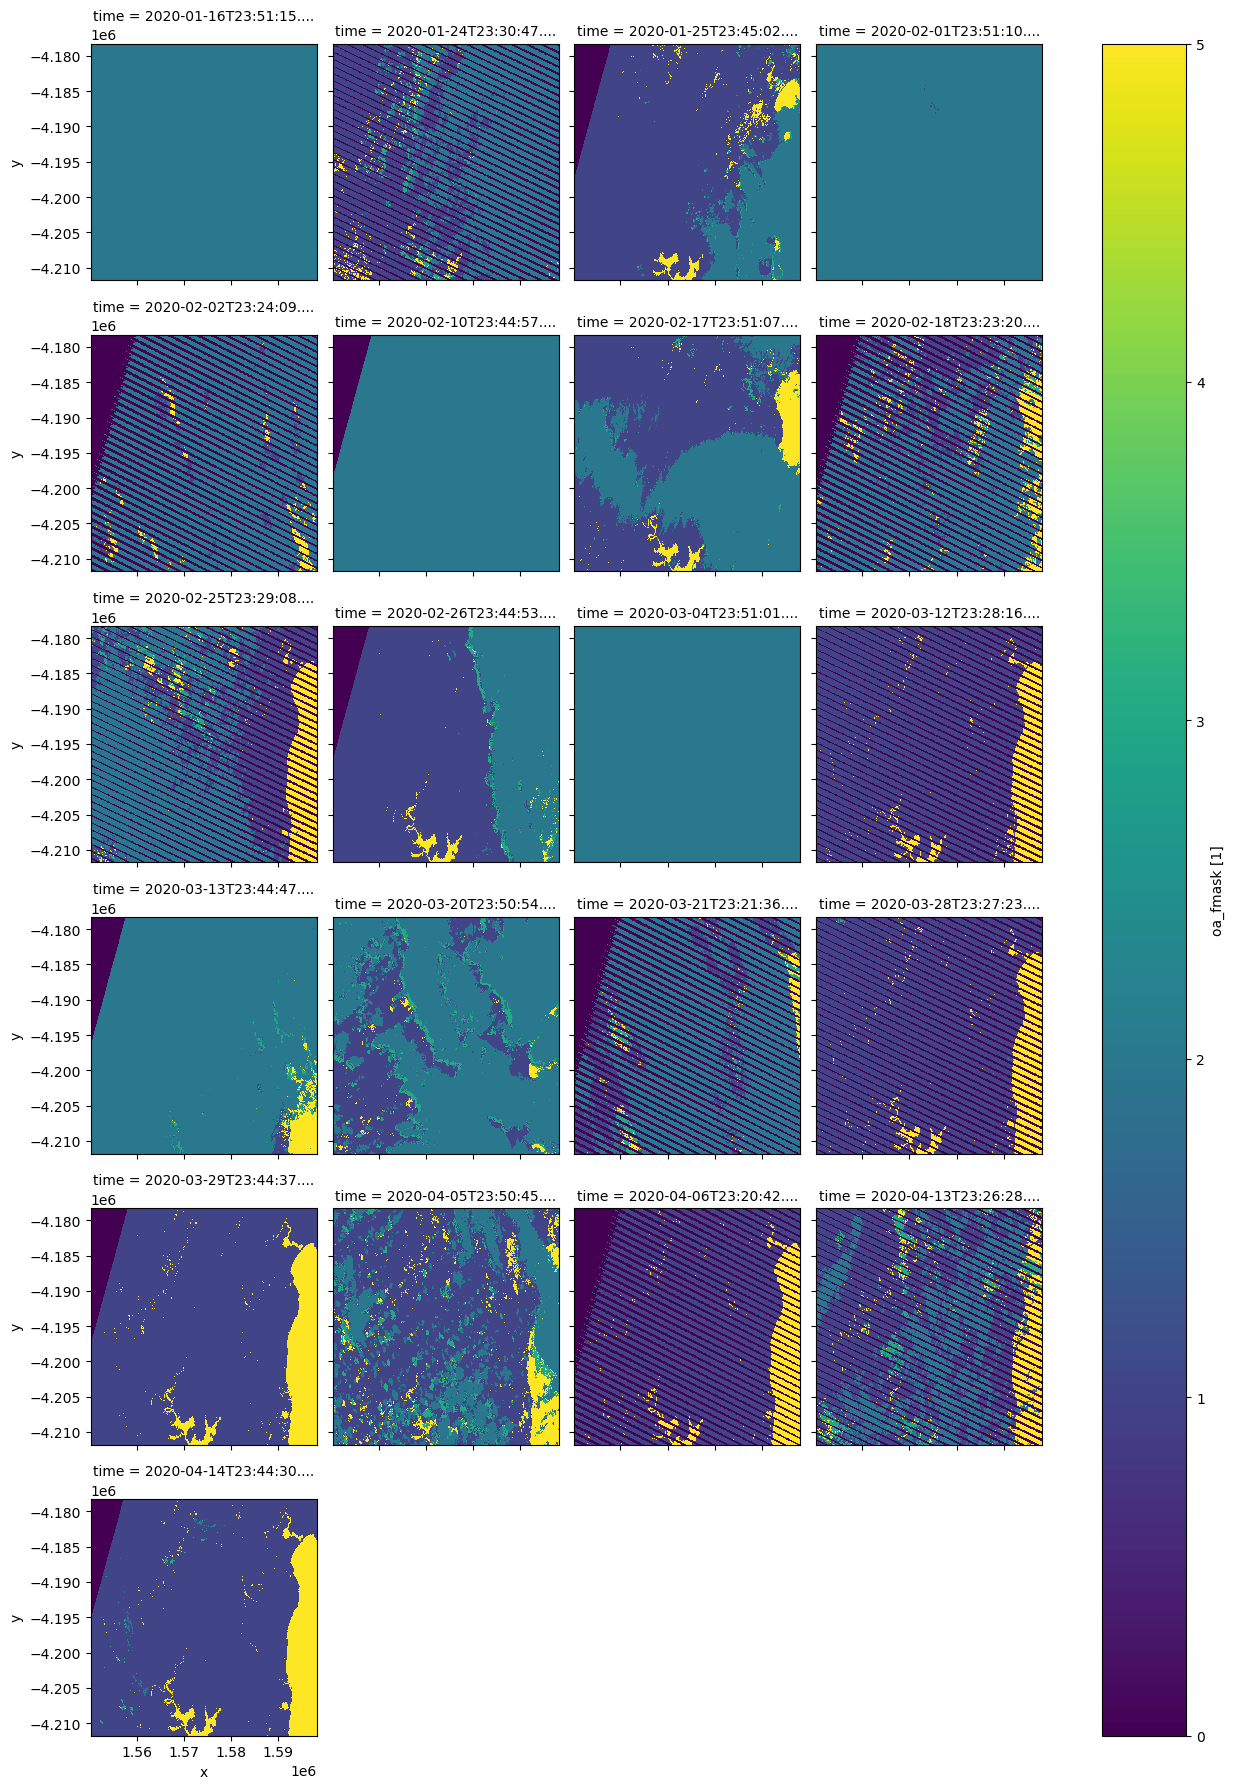

In [11]:
lazy_ds.oa_fmask.plot(col="time", col_wrap=4)

In [9]:
# Create the mask based on "valid" pixels
clear_mask = make_mask(lazy_ds.oa_fmask, fmask="valid")
clear_mask.plot(col="time", col_wrap=4)

In [10]:
# Apply the mask
clear = lazy_ds.where(clear_mask)


In [11]:
# Identify pixels that are either "valid", "water" or "snow"
cloud_free_mask = (
    make_mask(lazy_ds.oa_fmask, fmask="valid") | 
    make_mask(lazy_ds.oa_fmask, fmask="water") | 
    make_mask(lazy_ds.oa_fmask, fmask="snow")
)

# Apply the mask
cloud_free = lazy_ds.where(cloud_free_mask)

In [12]:
# Set invalid nodata pixels to NaN
valid_data = lazy_ds.oa_fmask.plot
valid_data

In [13]:
# Identify pixels that are either "cloud" or "cloud_shadow"
cloud_shadow_mask = (
    make_mask(lazy_ds.oa_fmask, fmask="cloud") | 
    make_mask(lazy_ds.oa_fmask, fmask="shadow")
)
# Plot
cloud_shadow_mask.plot(col="time", col_wrap=4)


In [14]:
# Dilate all cloud and cloud shadow pixels by 5 pixels in all directions
cloud_shadow_buffered = mask_cleanup(mask=cloud_shadow_mask,
                                     mask_filters=[("dilation", 5)])
cloud_shadow_buffered.plot(col="time", col_wrap=4)

In [15]:
# Apply the mask
buffered_cloud_free = lazy_ds.where(~cloud_shadow_buffered)


In [16]:
# Set invalid nodata pixels to NaN
valid_data = mask_invalid_data(buffered_cloud_free)

In [17]:
valid_data.nbart_red.isel(time=1)


<xarray.DataArray 'nbart_red' (y: 2033, x: 1730)>
dask.array<getitem, shape=(2033, 1730), dtype=float64, chunksize=(2033, 1730), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 2020-01-16T23:51:15.831480
  * y            (y) float64 -4.123e+06 -4.124e+06 ... -4.184e+06 -4.184e+06
  * x            (x) float64 1.554e+06 1.554e+06 ... 1.606e+06 1.606e+06
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        -999
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

From the Chunk column of the table, we can see that the data has been broken into four chunks, with each chunk having a shape of `(1 time, 2048 pixels, 2048 pixels)` and taking up a maximum of 8.00MiB of memory. 
Comparing this with the Array column, using Dask means that we can load four lots of less than 8.00MiB, rather than one lot of 19.77MiB. 

This is valuable when it comes to working with large areas or time-spans, as the entire array may not always fit into the memory available.
Breaking large datasets into chunks and loading chunks one at a time means that you can do computations over large areas without crashing the DEA environment.

## Loading lazy data

When working with lazy-loaded data, you have to specifically ask Dask to read and load data when you want to use it. 
Until you do this, the lazy-loaded dataset only knows where the data is, not its values.

To load the data from disk, call `.load()` on the `DataArray` or `Dataset`.
If you opened the Dask progress window, you should see the computation proceed there.

In [18]:
loaded_ds = valid_data.load()
loaded_ds

<xarray.Dataset>
Dimensions:       (time: 39, y: 2033, x: 1730)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-16T23:50:51.864078 ... 2020-0...
  * y             (y) float64 -4.123e+06 -4.124e+06 ... -4.184e+06 -4.184e+06
  * x             (x) float64 1.554e+06 1.554e+06 ... 1.606e+06 1.606e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) float64 nan nan nan nan ... 141.0 145.0 149.0
    nbart_red     (time, y, x) float64 nan nan nan nan ... 78.0 75.0 68.0 71.0
    nbart_blue    (time, y, x) float64 nan nan nan nan ... 269.0 271.0 267.0
    nbart_nir     (time, y, x) float64 nan nan nan nan ... 41.0 40.0 40.0 46.0
    nbart_swir_2  (time, y, x) float64 nan nan nan nan ... 16.0 13.0 11.0 12.0
    oa_fmask      (time, y, x) float64 nan nan nan nan nan ... 5.0 5.0 5.0 5.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

The Dask arrays constructed by the lazy load, e.g.:
```
red      (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
```
have now been replaced with actual numbers:
```
 red      (time, y, x) uint16 10967 11105 10773 10660 ... 12431 12410 12313
 ```

After applying the `.load()` command, the lazy-loaded data is the same as the data loaded from the first query.

We can now plot the data to verify it loaded correctly:

## Lazy operations

In addition to breaking data into smaller chunks that fit in memory, Dask has another advantage in that it can track how you want to work with the data, then only perform the necessary operations later.

We'll now explore how to do this by calculating the normalised difference vegetation index (NDVI) for our data.
To do this, we'll perform the lazy-load operation again, this time adding the near-infrared band (`nir`) to the `dc.load()` command:

In [19]:
valid_data

<xarray.Dataset>
Dimensions:       (time: 39, y: 2033, x: 1730)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-16T23:50:51.864078 ... 2020-0...
  * y             (y) float64 -4.123e+06 -4.124e+06 ... -4.184e+06 -4.184e+06
  * x             (x) float64 1.554e+06 1.554e+06 ... 1.606e+06 1.606e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) float64 nan nan nan nan ... 141.0 145.0 149.0
    nbart_red     (time, y, x) float64 nan nan nan nan ... 78.0 75.0 68.0 71.0
    nbart_blue    (time, y, x) float64 nan nan nan nan ... 269.0 271.0 267.0
    nbart_nir     (time, y, x) float64 nan nan nan nan ... 41.0 40.0 40.0 46.0
    nbart_swir_2  (time, y, x) float64 nan nan nan nan ... 16.0 13.0 11.0 12.0
    oa_fmask      (time, y, x) float64 nan nan nan nan nan ... 5.0 5.0 5.0 5.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Task graphs

When using lazy-loading, Dask breaks up the loading operation into a series of steps.
A useful way to visualise the steps is the task graph, which can be accessed by adding the `.visualize()` method to a `.data` call:

In [20]:
lazy_ds.nbart_red.data.visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

**The task graph is read from bottom to top.**

1. The rectangles at the bottom of the graph are the database entries describing the files that need to be read to load the data.

2. Above the rectangles are individual load commands that will do the reading.
There is one for each chunk.
The arrows describe which files need to be read for each operation: the chunk on the left needs data from all four database entries (i.e. four arrows), whereas the chunk on the right only needs data from one.

3. At the very top are the indexes of the chunks that will make up the final array.

### Multiple tasks

The power of using lazy-loading in Dask is that you can continue to chain operations together until you are ready to get the answer.

Here, we chain multiple steps together to calculate a new band for our array. Specifically, we use the `red` and `nir` bands to calculate the [Normalised Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) (NDVI), which can help identify areas of healthy vegetation.
For remote sensing data such as satellite imagery, it is defined as:

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})}, \\
\end{aligned}
$$

where $\text{NIR}$ is the near-infrared band of the data, and $\text{Red}$ is the red band:

In [21]:
# calc NDWI-investigate mndwi
band_diff = valid_data.nbart_green - valid_data.nbart_swir_2
band_sum = valid_data.nbart_green + valid_data.nbart_swir_2

valid_data["ndwi"] = band_diff / band_sum

Doing this adds the new `ndvi` Dask array to the `lazy_data` dataset:

In [22]:
valid_data

<xarray.Dataset>
Dimensions:       (time: 39, y: 2033, x: 1730)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-16T23:50:51.864078 ... 2020-0...
  * y             (y) float64 -4.123e+06 -4.124e+06 ... -4.184e+06 -4.184e+06
  * x             (x) float64 1.554e+06 1.554e+06 ... 1.606e+06 1.606e+06
    spatial_ref   int32 3577
Data variables:
    nbart_green   (time, y, x) float64 nan nan nan nan ... 141.0 145.0 149.0
    nbart_red     (time, y, x) float64 nan nan nan nan ... 78.0 75.0 68.0 71.0
    nbart_blue    (time, y, x) float64 nan nan nan nan ... 269.0 271.0 267.0
    nbart_nir     (time, y, x) float64 nan nan nan nan ... 41.0 40.0 40.0 46.0
    nbart_swir_2  (time, y, x) float64 nan nan nan nan ... 16.0 13.0 11.0 12.0
    oa_fmask      (time, y, x) float64 nan nan nan nan nan ... 5.0 5.0 5.0 5.0
    ndwi          (time, y, x) float64 nan nan nan nan ... 0.8312 0.859 0.8509
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [23]:
valid_data.ndwi

<xarray.DataArray 'ndwi' (time: 39, y: 2033, x: 1730)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.09797437,
          0.66602192,  0.83421251],
        [        nan,         nan,         nan, ..., -0.02511477,
          0.75670618,  0.85204082],
        [        nan,         nan,         nan, ..., -0.00163773,
          0.6403385 ,  0.88608414],
        ...,
        [-0.17440402, -0.10886076, -0.11416781, ...,  0.80606061,
          0.76331361,  0.82165605],
        [-0.16129032, -0.11914324, -0.12876712, ...,  0.77777778,
          0.82389937,  0.83116883],
        [-0.20619785, -0.18618989, -0.18618989, ...,  0.83116883,
          0.85897436,  0.85093168]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-01-16T23:50:51.864078 ... 2020-04...
  * y            (y) float64 -4.123e+06 -4.124e+06 ... -4.184e+06 -4.184e+06
  * x            (x) float64 1.554e+06 1.554e+06 ... 1.606e+06 1.606e+06
    spatial_ref  int32 3577

Now that the operation is defined, we can view its task graph:

In [34]:
valid_data.ndwi.visualize()

AttributeError: 'DataArray' object has no attribute 'visualize'

In [24]:
import matplotlib.pyplot as plt

# Assuming `ndwi` is your DataArray variable

# Plot the NDWI data
plt.imshow(ndwi)
plt.colorbar()
plt.title("NDWI")
plt.show()


NameError: name 'ndwi' is not defined

Reading the graph bottom-to-top, we can see the equation taking place. The `add` and `sub` are performed on each band before being divided (`truediv`).

We can see how each output chunk is independent from the others.  This means we could calculate each chunk without ever having to load all of the bands into memory at the same time.

Finally, we can calculate the NDVI values and load the result into memory by calling the `.load()` command.
We'll store the result in the `ndvi_load` variable:

In [25]:
ndwi_load = valid_data.ndwi.load()
ndwi_load

<xarray.DataArray 'ndwi' (time: 39, y: 2033, x: 1730)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.09797437,
          0.66602192,  0.83421251],
        [        nan,         nan,         nan, ..., -0.02511477,
          0.75670618,  0.85204082],
        [        nan,         nan,         nan, ..., -0.00163773,
          0.6403385 ,  0.88608414],
        ...,
        [-0.17440402, -0.10886076, -0.11416781, ...,  0.80606061,
          0.76331361,  0.82165605],
        [-0.16129032, -0.11914324, -0.12876712, ...,  0.77777778,
          0.82389937,  0.83116883],
        [-0.20619785, -0.18618989, -0.18618989, ...,  0.83116883,
          0.85897436,  0.85093168]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-01-16T23:50:51.864078 ... 2020-04...
  * y            (y) float64 -4.123e+06 -4.124e+06 ... -4.184e+06 -4.184e+06
  * x            (x) float64 1.554e+06 1.554e+06 ... 1.606e+06 1.606e+06
    spatial_ref  int32 3577

We can plot a subset of our NDVI data to verify that Dask correctly calculated our sequence of tasks. 
Vegetation should appear in green (indicating high NDVI values), and non-vegetation in red (indicating low NDVI values, e.g. over water):

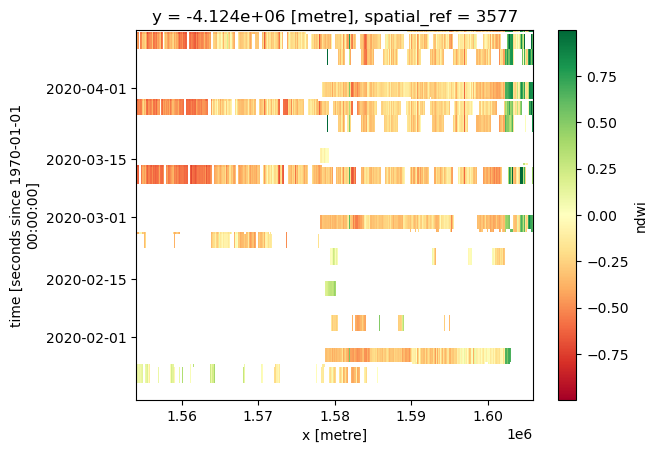

In [26]:
ndwi_load[:, 19].plot(cmap="RdYlGn")

Note that running the `.load()` command also modifies the `ndvi` entry in the `lazy_load` dataset:

In [27]:
valid_data.ndwi

<xarray.DataArray 'ndwi' (time: 39, y: 2033, x: 1730)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.09797437,
          0.66602192,  0.83421251],
        [        nan,         nan,         nan, ..., -0.02511477,
          0.75670618,  0.85204082],
        [        nan,         nan,         nan, ..., -0.00163773,
          0.6403385 ,  0.88608414],
        ...,
        [-0.17440402, -0.10886076, -0.11416781, ...,  0.80606061,
          0.76331361,  0.82165605],
        [-0.16129032, -0.11914324, -0.12876712, ...,  0.77777778,
          0.82389937,  0.83116883],
        [-0.20619785, -0.18618989, -0.18618989, ...,  0.83116883,
          0.85897436,  0.85093168]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-01-16T23:50:51.864078 ... 2020-04...
  * y            (y) float64 -4.123e+06 -4.124e+06 ... -4.184e+06 -4.184e+06
  * x            (x) float64 1.554e+06 1.554e+06 ... 1.606e+06 1.606e+06
    spatial_ref  int32 3577

In [28]:
import rasterio
import xarray as xr

# Extract the NDWI data variable
ndwi_data = valid_data['ndwi']

# Set the threshold
threshold = 0.3  # Adjust as per your requirement

# Create a binary water or no water raster
binary_data = ndwi_data > threshold



You can see that `ndvi` is a number, whereas all the other variables are Dask arrays.

In [29]:
# Calculate total wetness through time
wet_pixels = ndwi_data.sum(dim=['time'])

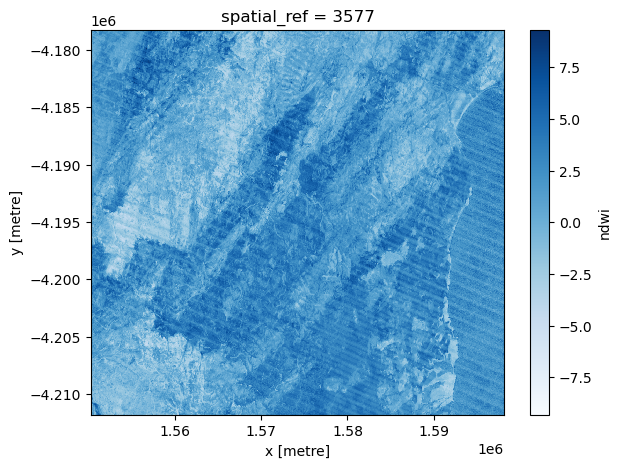

In [41]:
wet_pixels.plot(size=5, cmap='Blues')

In [30]:
#wet_pixels = wo.isel(time=-0).to_array()

from datacube.utils.cog import write_cog

write_cog (geo_im=wet_pixels,
          fname='./wetpixelsslice_2.tif',
          overwrite=True)

PosixPath('wetpixelsslice_2.tif')

### Keeping variables as Dask arrays
If you wanted to calculate the NDVI values, but leave `ndvi` as a dask array in `lazy_load`, you can use the `.compute()` command instead.

To demonstrate this, we first redefine the `ndvi` variable so that it becomes a Dask array again:

In [50]:
valid_data["ndvwi"] = band_diff / band_sum
valid_data

<xarray.Dataset>
Dimensions:      (time: 21, y: 1118, x: 1597)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-16T23:51:15.831480 ... 2020-04...
  * y            (y) float64 -4.178e+06 -4.178e+06 ... -4.212e+06 -4.212e+06
  * x            (x) float64 1.55e+06 1.55e+06 1.55e+06 ... 1.598e+06 1.598e+06
    spatial_ref  int32 3577
Data variables:
    green        (time, y, x) float64 nan nan nan nan ... 139.0 142.0 138.0
    red          (time, y, x) float64 nan nan nan nan ... 74.0 74.0 78.0 75.0
    blue         (time, y, x) float64 nan nan nan nan ... 266.0 258.0 257.0
    nir          (time, y, x) float64 nan nan nan nan ... 38.0 38.0 39.0 43.0
    swir_2       (time, y, x) float64 nan nan nan nan ... 16.0 16.0 12.0 15.0
    fmask        (time, y, x) float64 nan nan nan nan nan ... 5.0 5.0 5.0 5.0
    ndwi         (time, y, x) float64 nan nan nan nan ... 0.4074 0.5294 0.4828
    ndvwi        (time, y, x) float64 nan nan nan nan ... 0.4074 0.5294 0.4828
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

Now, we perform the same steps as before to calculate NDVI, but use `.compute()` instead of `.load()`:

In [51]:
ndvi_compute = valid_data.ndwi.compute()
ndvi_compute

<xarray.DataArray 'ndwi' (time: 21, y: 1118, x: 1597)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 5.28094635e-02,  6.07457059e-02,  7.47740345e-02, ...,
                     nan,             nan,             nan],
        [ 4.72440945e-02,  2.35492010e-02,  1.10288066e-01, ...,
                     nan,             nan,             nan],
        [ 3.79858657e-02,  9.95106036e-02,  2.58181818e-01, ...,
                     nan,             nan,             nan],
...
        [-2.45614035e-02,  6.74100355e-02,  7.60869565e-02, ...,
          9.85294118e-01,  2.00000000e-01,  5.16853933e-01],
        [ 2.12089077e-03,  4.70409712e-02,  1.74206968e-01, ...,
          5.16853933e-01,  5.16853933e-01,  2.18181818e-01],
        [ 7.09180869e-02,  5.98290598e-02,  1.50127226e-01, ...,
          2.00000000e-01,  2.18181818e-01,  5.16853933e-01]],

       [[            nan,             nan,             nan, ...,
         -1.91857745e-02, -1.57488987e-01, -1.47956246e-01],
        [            nan,             nan,             nan, ...,
          1.61051462e-01, -4.75059382e-04,  1.89840944e-02],
        [            nan,             nan,             nan, ...,
          1.61051462e-01,  1.07004727e-01, -6.17678381e-02],
        ...,
        [ 6.03248260e-03,  6.60749507e-02,  1.41732283e-02, ...,
          5.29411765e-01,  4.18181818e-01,  3.44827586e-01],
        [-2.55623722e-02,  3.88692580e-02,  2.77078086e-02, ...,
          5.18518519e-01,  5.00000000e-01,  5.41666667e-01],
        [-2.57966616e-02,  4.56176320e-02,  5.07968127e-02, ...,
          4.07407407e-01,  5.29411765e-01,  4.82758621e-01]]])
Coordinates:
  * time         (time) datetime64[ns] 2020-01-16T23:51:15.831480 ... 2020-04...
  * y            (y) float64 -4.178e+06 -4.178e+06 ... -4.212e+06 -4.212e+06
  * x            (x) float64 1.55e+06 1.55e+06 1.55e+06 ... 1.598e+06 1.598e+06
    spatial_ref  int32 3577

You can see that the values have been calculated, but as shown below, the `ndvi` variable is kept as a Dask array.

In [52]:
valid_data

<xarray.Dataset>
Dimensions:      (time: 21, y: 1118, x: 1597)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-16T23:51:15.831480 ... 2020-04...
  * y            (y) float64 -4.178e+06 -4.178e+06 ... -4.212e+06 -4.212e+06
  * x            (x) float64 1.55e+06 1.55e+06 1.55e+06 ... 1.598e+06 1.598e+06
    spatial_ref  int32 3577
Data variables:
    green        (time, y, x) float64 nan nan nan nan ... 139.0 142.0 138.0
    red          (time, y, x) float64 nan nan nan nan ... 74.0 74.0 78.0 75.0
    blue         (time, y, x) float64 nan nan nan nan ... 266.0 258.0 257.0
    nir          (time, y, x) float64 nan nan nan nan ... 38.0 38.0 39.0 43.0
    swir_2       (time, y, x) float64 nan nan nan nan ... 16.0 16.0 12.0 15.0
    fmask        (time, y, x) float64 nan nan nan nan nan ... 5.0 5.0 5.0 5.0
    ndwi         (time, y, x) float64 nan nan nan nan ... 0.4074 0.5294 0.4828
    ndvwi        (time, y, x) float64 nan nan nan nan ... 0.4074 0.5294 0.4828
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [55]:
# Calculate mean wetness through time
wo_freq = valid_data.mean(dim=['time'])


In [59]:
#Calculate max wetness through time
wo_max = valid_data.sum(dim=['time'])


In [67]:
from datacube.utils.cog import write_cog

In [72]:
# Run `write_cog`
wo_max = write_cog(geo_im=valid_data.isel(time=0).to_array(), 
                   fname='NDWI_geotiff.tif',
                   overwrite=True)

# Compute the result
result = valid_data.compute()

# Print the result
print(result)


<xarray.Dataset>
Dimensions:      (time: 21, y: 1118, x: 1597)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-16T23:51:15.831480 ... 2020-04...
  * y            (y) float64 -4.178e+06 -4.178e+06 ... -4.212e+06 -4.212e+06
  * x            (x) float64 1.55e+06 1.55e+06 1.55e+06 ... 1.598e+06 1.598e+06
    spatial_ref  int32 3577
Data variables:
    green        (time, y, x) float64 nan nan nan nan ... 139.0 142.0 138.0
    red          (time, y, x) float64 nan nan nan nan ... 74.0 74.0 78.0 75.0
    blue         (time, y, x) float64 nan nan nan nan ... 266.0 258.0 257.0
    nir          (time, y, x) float64 nan nan nan nan ... 38.0 38.0 39.0 43.0
    swir_2       (time, y, x) float64 nan nan nan nan ... 16.0 16.0 12.0 15.0
    fmask        (time, y, x) float64 nan nan nan nan nan ... 5.0 5.0 5.0 5.0
    ndwi         (time, y, x) float64 nan nan nan nan ... 0.4074 0.5294 0.4828
    ndvwi        (time, y, x) float64 nan nan nan nan ... 0.4074 0.5294 0.4828
Attributes:
    crs:

In [74]:
singleband_da = valid_data.ndwi.isel(time=0).to_array(),

AttributeError: 'DataArray' object has no attribute 'to_array'

Using `.compute()` can allow you to calculate in-between steps and store the results, without modifying the original Dask dataset or array. 
However, be careful when using `.compute()`, as it may lead to confusion about what you have and have not modified, as well as multiple computations of the same quantity.

### Shutting down the Dask client
To free up computing resources for future work, we can close the Dask client once we are finished:

In [22]:
client.close()

## Recommended next steps

### Further resources

For further reading on how Dask works, and how it is used by `xarray`, see these resources:

 * http://xarray.pydata.org/en/stable/dask.html
 * https://dask.readthedocs.io/en/latest/
 * http://stephanhoyer.com/2015/06/11/xray-dask-out-of-core-labeled-arrays/

### Other notebooks
You have now completed the full beginner's guide tutorial!

1. [Jupyter Notebooks](01_Jupyter_notebooks.ipynb)
2. [Digital Earth Australia](02_DEA.ipynb)
3. [Products and Measurements](03_Products_and_measurements.ipynb)
4. [Loading data](04_Loading_data.ipynb)
5. [Plotting](05_Plotting.ipynb)
6. [Performing a basic analysis](06_Basic_analysis.ipynb)
7. [Introduction to numpy](07_Intro_to_numpy.ipynb)
8. [Introduction to xarray](08_Intro_to_xarray.ipynb)
9. **Parallel processing with Dask (this notebook)**

You can now join more advanced users in exploring:

* The "DEA_products" directory in the repository, where you can explore DEA products in depth.
* The "How_to_guides" directory, which contains a recipe book of common techniques and methods for analysing DEA data.
* The "Real_world_examples" directory, which provides more complex workflows and analysis case studies.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2023

**Compatible `datacube` version:** 

In [23]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)